In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder, label_binarize
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc, roc_auc_score
from sklearn.feature_selection import RFE
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_decision_regions

In [2]:
df = pd.read_csv('/Users/laurelxu/Desktop/ECS 171/Final Project/data.csv')
df.head()

,Rank,Game,Month,Year,Hours_watched,Hours_streamed,Peak_viewers,Peak_channels,Streamers,Avg_viewers,Avg_channels,Avg_viewer_ratio,Genre,Release_Year,Release_Month,New_Game,Wrong,rank_category
0,1,League of Legends,1,2016,94377226,1362044,530270,2903,129172,127021,1833,69.29,"Role-playing (RPG), Strategy, MOBA",2009,10,0.0,0.0,Top 10
1,2,Counter-Strike: Global Offensive,1,2016,47832863,830105,372654,2197,120849,64378,1117,57.62,"Shooter, Tactical",2012,08,0.0,0.0,Top 10
2,3,Dota 2,1,2016,45185893,433397,315083,1100,44074,60815,583,104.26,"Strategy, MOBA",2013,07,0.0,0.0,Top 10
3,4,Hearthstone,1,2016,39936159,235903,131357,517,36170,53749,317,169.29,"Strategy, Turn-based strategy (TBS), Card & Bo...",2014,03,0.0,0.0,Top 10
4,5,Call of Duty: Black Ops III,1,2016,16153057,1151578,71639,3620,214054,21740,1549,14.03,Shooter,2015,11,0.0,0.0,Top 10


In [3]:
label_encoder = LabelEncoder()
df['rank_category'] = label_encoder.fit_transform(df['rank_category'])

X = df[['Hours_streamed', 'Peak_viewers', 'Peak_channels', 'Streamers', 'Avg_viewers', 'Avg_channels']]
y = df['rank_category']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

feature_names = X_train.columns 

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Selected Features: Index(['Hours_streamed', 'Peak_channels', 'Avg_viewers'], dtype='object')


/var/folders/r2/19qqvq2s2r98_0dqh9mb5vsm0000gn/T/ipykernel_32085/1551147252.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x = 'RFE_Ranking', y = 'Feature', data = rfe_ranking_df, palette = 'viridis', orient = 'h')


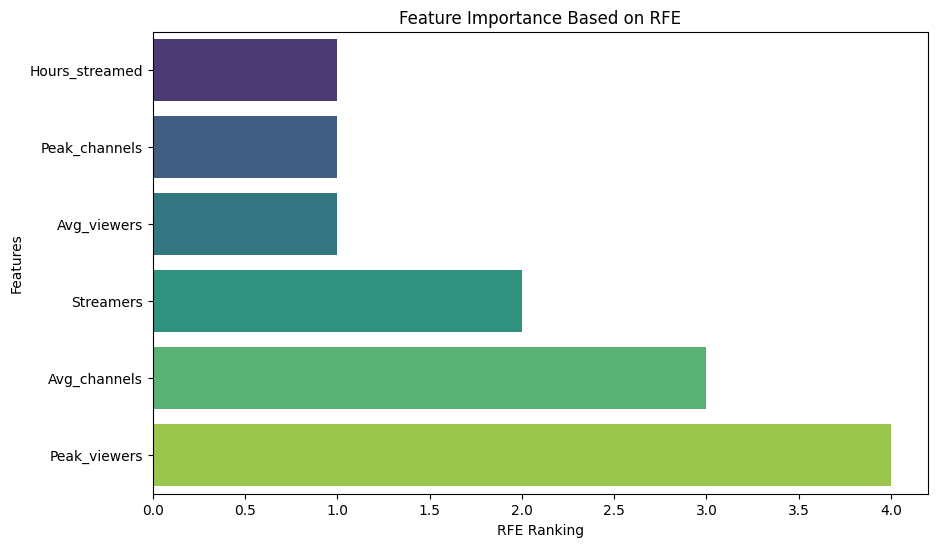

In [4]:
svm_model = SVC(kernel = 'linear')

rfe = RFE(svm_model, n_features_to_select = 3)
rfe.fit(X_train, y_train)

selected_features = feature_names[rfe.support_]
print('Selected Features:', selected_features)

rfe_ranking_df = pd.DataFrame({'Feature': feature_names, 'RFE_Ranking': rfe.ranking_})
rfe_ranking_df = rfe_ranking_df.sort_values(by = 'RFE_Ranking')

plt.figure(figsize = (10, 6))
sns.barplot(x = 'RFE_Ranking', y = 'Feature', data = rfe_ranking_df, palette = 'viridis', orient = 'h')

plt.xlabel('RFE Ranking')
plt.ylabel('Features')
plt.title('Feature Importance Based on RFE')
plt.show()

Training Accuracy: 0.7693
Testing Accuracy: 0.7726
              precision    recall  f1-score   support

      Top 10       0.92      0.75      0.83       221
     Top 100       0.67      0.44      0.53      1036
     Top 200       0.78      0.98      0.87      2088
      Top 50       0.82      0.67      0.74       855

    accuracy                           0.77      4200
   macro avg       0.80      0.71      0.74      4200
weighted avg       0.77      0.77      0.76      4200



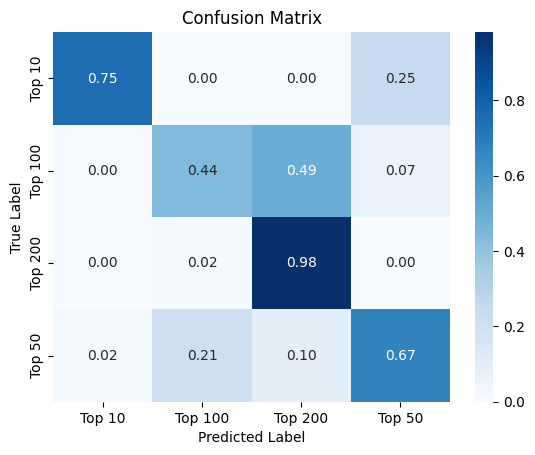

In [5]:
# X = df[['Hours_streamed', 'Peak_channels', 'Avg_viewers']] - Accuracy 0.7717
# X = df[['Hours_streamed', 'Peak_channels']] - Accuracy 0.6090
# X = df[['Avg_viewers']] - Accuracy 0.7714
# X = df[['Hours_streamed']] - Accuracy 0.6093
# X = df[['Peak_channels']] - Accuracy 0.5910
X = df[['Peak_channels', 'Avg_viewers']]
y = df['rank_category']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

svm_model = SVC(kernel = 'rbf', C = 1.0, gamma = 'scale')
svm_model.fit(X_train, y_train)

y_train_pred = svm_model.predict(X_train)

y_train_pred_orig = label_encoder.inverse_transform(y_train_pred)
y_train_orig = label_encoder.inverse_transform(y_train)

train_accuracy = accuracy_score(y_train_orig, y_train_pred_orig)
print(f'Training Accuracy: {train_accuracy:.4f}')

y_pred = svm_model.predict(X_test)

y_pred_orig = label_encoder.inverse_transform(y_pred)
y_test_orig = label_encoder.inverse_transform(y_test)

accuracy = accuracy_score(y_test_orig, y_pred_orig)
print(f'Testing Accuracy: {accuracy:.4f}')

print(classification_report(y_test_orig, y_pred_orig))

conf_matrix = confusion_matrix(y_test_orig, y_pred_orig)
categories = label_encoder.classes_
conf_matrix_normalized = conf_matrix.astype("float") / conf_matrix.sum(axis=1, keepdims=True)
sns.heatmap(conf_matrix_normalized, annot=True, cmap="Blues", fmt=".2f", xticklabels=categories, yticklabels=categories)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [6]:
param_grid = {
    'C': [1, 5, 10, 15],
    'gamma': ['scale', 0.01, 0.1, 'auto'],
    'kernel': ['rbf']
}
cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)
grid_search = GridSearchCV(SVC(), param_grid, cv = cv, scoring = 'accuracy', n_jobs = -1)
grid_search.fit(X_train, y_train)

print('Best Parameters:', grid_search.best_params_)

best_svm = grid_search.best_estimator_
y_pred_best = best_svm.predict(X_test)

accuracy_best = accuracy_score(y_test, y_pred_best)
print(f'Optimized Accuracy: {accuracy_best:.4f}')

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best Parameters: {'C': 15, 'gamma': 'scale', 'kernel': 'rbf'}
Optimized Accuracy: 0.7729


Training Accuracy: 0.7715
Testing Accuracy: 0.7729
              precision    recall  f1-score   support

      Top 10       0.91      0.76      0.82       221
     Top 100       0.65      0.47      0.55      1036
     Top 200       0.78      0.98      0.87      2088
      Top 50       0.85      0.65      0.73       855

    accuracy                           0.77      4200
   macro avg       0.80      0.71      0.74      4200
weighted avg       0.77      0.77      0.76      4200



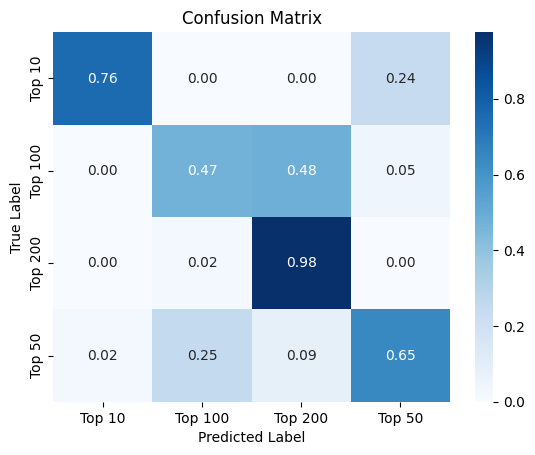

In [7]:
X = df[['Peak_channels', 'Avg_viewers']]
y = df['rank_category']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

svm_model = SVC(kernel = 'rbf', C = 15, gamma = 'scale')
svm_model.fit(X_train, y_train)

y_train_pred = svm_model.predict(X_train)

y_train_pred_orig = label_encoder.inverse_transform(y_train_pred)
y_train_orig = label_encoder.inverse_transform(y_train)

train_accuracy = accuracy_score(y_train_orig, y_train_pred_orig)
print(f'Training Accuracy: {train_accuracy:.4f}')

y_pred = svm_model.predict(X_test)

y_pred_orig = label_encoder.inverse_transform(y_pred)
y_test_orig = label_encoder.inverse_transform(y_test)

accuracy = accuracy_score(y_test_orig, y_pred_orig)
print(f'Testing Accuracy: {accuracy:.4f}')

print(classification_report(y_test_orig, y_pred_orig))

conf_matrix = confusion_matrix(y_test_orig, y_pred_orig)
categories = label_encoder.classes_
conf_matrix_normalized = conf_matrix.astype("float") / conf_matrix.sum(axis=1, keepdims=True)
sns.heatmap(conf_matrix_normalized, annot=True, cmap="Blues", fmt=".2f", xticklabels=categories, yticklabels=categories)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

Multi-Class AUC Score: 0.9058


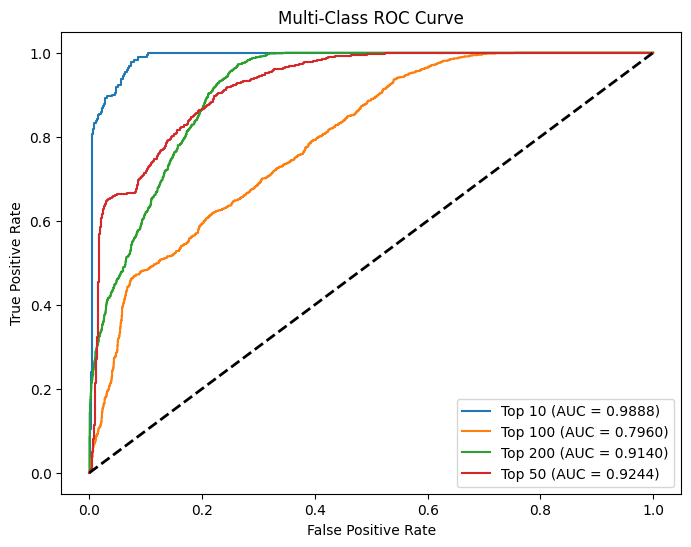

In [8]:
y_test_bin = label_binarize(y_test, classes = np.arange(len(categories)))
y_pred_prob = svm_model.decision_function(X_test)

auc_score = roc_auc_score(y_test_bin, y_pred_prob, multi_class='ovr')
print(f'Multi-Class AUC Score: {auc_score:.4f}')

plt.figure(figsize = (8, 6))

for i, category in enumerate(categories):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{category} (AUC = {roc_auc:.4f})')

plt.plot([0, 1], [0, 1], 'k--', lw = 2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-Class ROC Curve')
plt.legend(loc = 'best')
plt.show()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/mlxtend/plotting/decision_regions.py:346: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(


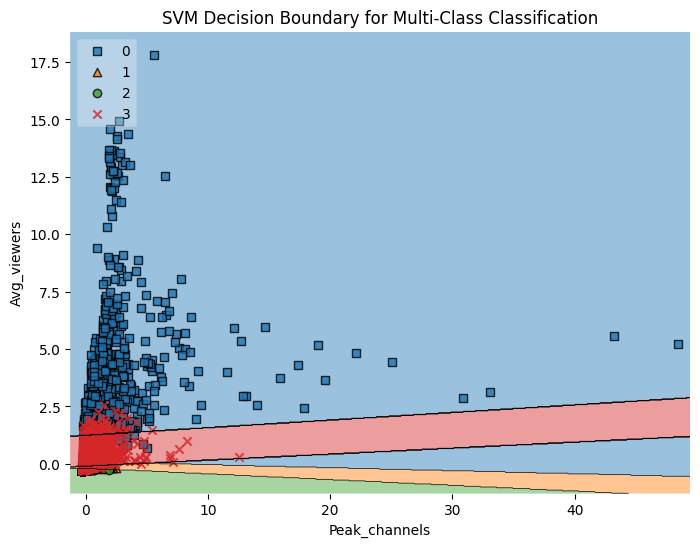

In [9]:
y_encoded = LabelEncoder().fit_transform(y_train)

svm_clf = SVC(kernel = 'linear', decision_function_shape = 'ovr', random_state = 42)
svm_clf.fit(X_train[:, :2], y_encoded)

plt.figure(figsize = (8, 6))
plot_decision_regions(X_train[:, :2], y_encoded, clf = svm_clf, legend = 2)
plt.xlabel('Peak_channels')
plt.ylabel('Avg_viewers')
plt.title('SVM Decision Boundary for Multi-Class Classification')
plt.show()